# **Package importation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers==2.8.0

In [ ]:
import os
import json
import time
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import multiprocessing
cores = multiprocessing.cpu_count()
import pickle
from sklearn.utils import shuffle

from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

# Functions : preprocess() (create dataloaders from raw data) 
# load_models() (load tokenizers and models) training() (loop of one training step) evaluate()

# **Data uploading and preparing**

In [ ]:
#upload the preprocessed dataset
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Agon.csv")
dataset.head()

,Unnamed: 0,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic,newText,WordFrequency,AvgFreq,Cognates,ReadScore,AvgFreqStd,ReadScoreStd,cog,hasCog,NumOfCog
0,0,est pour quand,1,"['est', 'pour', 'quand']","['AUX', 'ADP', 'SCONJ']","[0.0, 0.0, 0.0]",0.000,est pour quand,"[15.6, 14.57, 13.15]",0.959484,NaN,0.993116,0.040516,0.006884,NaN,0,0
1,1,Je pense que est bon,1,"['Je', 'pense', 'que', 'est', 'bon']","['PRON', 'VERB', 'SCONJ', 'AUX', 'ADJ']","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000,Je pense que est bon,"[15.78, 12.24, 15.29, 15.6, 12.93]",0.953108,NaN,0.986232,0.046892,0.013768,NaN,0,0
2,2,est pas mal,1,"['est', 'pas', 'mal']","['AUX', 'ADV', 'NOUN']","[0.0, 0.0, 0.0]",0.000,est pas mal,"[15.6, 15.43, 12.15]",0.955352,NaN,0.993116,0.044648,0.006884,NaN,0,0
3,3,Qu est ce que vous faites,1,"['Qu', 'est', 'ce', 'que', 'vous', 'faites']","['PRON', 'AUX', 'PRON', 'PRON', 'PRON', 'VERB']","[0.03, 0.0, 0.0, 0.0, 0.0, 0.0]",0.007,Qu est ce que vous faites,"[9.21, 15.6, 14.59, 15.29, 15.16, 11.58]",0.882586,NaN,0.982773,0.117414,0.017227,NaN,0,0
4,4,est bien,1,"['est', 'bien']","['AUX', 'ADV']","[0.0, 0.0]",0.000,est bien,"[15.6, 14.03]",0.992694,NaN,0.996541,0.007306,0.003459,NaN,0,0


In [ ]:
#deleting all useless columns for the camambert model
dataset.drop(['Unnamed: 0', 'Word', 'Types', 'WordDifficulty', 'AvgWordDiffic', 'newText', 'WordFrequency', 'AvgFreq', 'Cognates', 'ReadScore', 'AvgFreqStd', 'ReadScoreStd', 'cog', 'hasCog', 'NumOfCog'], axis=1, inplace=True)
dataset

,Text,Difficulty
0,est pour quand,1
1,Je pense que est bon,1
2,est pas mal,1
3,Qu est ce que vous faites,1
4,est bien,1
...,...,...
4795,Le problème va du garçon de café tentant inint...,6
4796,Les lois de programmation mentionnées antépénu...,6
4797,La conscience malheureuse est donc le mauvais ...,6
4798,Comme Monsieur un informaticien fondateur de l...,6


In [ ]:
#The 5 code below are aimed to delete proportionally 75% of rows for having enough colab ram to run completely the model

In [ ]:
dataset = dataset.drop(range(4199,4799))


In [ ]:
dataset = dataset.drop(range(3399,3999))

In [ ]:
dataset = dataset.drop(range(2599,3199))

In [ ]:
dataset = dataset.drop(range(1799,2399))

In [ ]:
dataset = dataset.drop(range(999,1599))

In [ ]:
dataset = dataset.drop(range(199,799))

In [ ]:
#normalizing the difficulty for having a same comparing base difficulty level of the other iterations of the camambert model
dataset = dataset.replace([1, 2, 3, 4, 5, 6], [0,1,2,3,4,5])
dataset

,Text,Difficulty
0,est pour quand,0
1,Je pense que est bon,0
2,est pas mal,0
3,Qu est ce que vous faites,0
4,est bien,0
...,...,...
4195,Nous lisions ensemble des poètes anglais nous ...,5
4196,Car la tentation minutieusement encouragée par...,5
4197,Puis quand ils eurent dépassé le bûcheron celu...,5
4198,Pour conjurer les deux mois de vacances ils ac...,5


In [ ]:
#rename the columns 
dataset.columns = ['review','sentiment']
dataset

,review,sentiment
0,est pour quand,0
1,Je pense que est bon,0
2,est pas mal,0
3,Qu est ce que vous faites,0
4,est bien,0
...,...,...
4195,Nous lisions ensemble des poètes anglais nous ...,5
4196,Car la tentation minutieusement encouragée par...,5
4197,Puis quand ils eurent dépassé le bûcheron celu...,5
4198,Pour conjurer les deux mois de vacances ils ac...,5


In [ ]:
#shuffling all the columns because we notice that our camembert model processed differently if there is no order in the dataset
dataset = shuffle(dataset)
dataset


,review,sentiment
3279,Dans son livre Guide de survie pour accros aux...,4
2551,La motocyclette était très peu fiable ses débuts,3
1766,Il rencontré un grand succès dans les écoles,2
32,Qu est ce qu ils font,0
1652,As tu prévu quelque chose,2
...,...,...
3264,Enfin la délivrance après soixante quatorze jo...,4
2547,Je la considérais comme une créature céleste,3
818,Ce était pas le cas il cent ans et est très bien,1
2413,Une petite marque au front des cicatrices sur ...,3


## **Camembert Model**

In [ ]:
reviews = dataset['review'].values.tolist()
sentiments = dataset['sentiment'].values.tolist()

TOKENIZER = CamembertTokenizer.from_pretrained(
    'camembert-base',
    do_lower_case=True)

In [ ]:
def preprocess(raw_reviews, sentiments=None):
    """
    Cette fonction prends de la donnée brute en argument et retourne un 'dataloader' pytorch

    Args
        raw_reviews (array-like) : Une liste de reviews sous forme de 'str'
        
        sentiments : Une liste 'sentiments' (0 = negatif, 1 = positif) de la meme taille que
                     'raw_review'
    
    Returns
        inputs_ids, attention_masks, sentiments(optionel) : Objet  de PyTorch qui contient 
                    les versions tokenisees et encodees des donnees brutes
    """

    

    encoded_batch = TOKENIZER.batch_encode_plus(raw_reviews,
                                                add_special_tokens=False,
                                                pad_to_max_length=True,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    if sentiments:
        sentiments = torch.tensor(sentiments)
        return encoded_batch['input_ids'], encoded_batch['attention_mask'], sentiments
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

In [ ]:
# Split train-validation
split_border = int(len(sentiments)*0.8)
reviews_train, reviews_validation = reviews[:split_border], reviews[split_border:]
sentiments_train, sentiments_validation = sentiments[:split_border], sentiments[split_border:]

In [ ]:
input_ids, attention_mask, sentiments_train = preprocess(reviews_train, sentiments_train)
# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    input_ids,
    attention_mask,
    sentiments_train)

input_ids, attention_mask, sentiments_validation = preprocess(reviews_validation, sentiments_validation)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    input_ids,
    attention_mask,
    sentiments_validation)

In [ ]:
# size of 16 or 32.
batch_size = 5

# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

In [ ]:
try:
    state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/u.pt")
    print("Loading trained model...")
    model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    state_dict=state_dict)
    print("Trained model loaded!")
except Exception as e:
    print("Enable to load trained model.")
    print(e)
    model = CamembertForSequenceClassification.from_pretrained(
        'camembert-base',
        num_labels = 6)

Loading trained model...
Enable to load trained model.
Error(s) in loading state_dict for CamembertForSequenceClassification:
	size mismatch for classifier.out_proj.weight: copying a param with shape torch.Size([6, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
	size mismatch for classifier.out_proj.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


In [ ]:
def predict(reviews, model=model):
    with torch.no_grad():
        model.eval()
        input_ids, attention_mask = preprocess(reviews)
        retour = model(input_ids, attention_mask=attention_mask)
        print(retour)
        return torch.argmax(retour[0], dim=1)

In [ ]:
def evaluate(reviews, sentiments, metric='report'):
    predictions = predict(reviews)
    if metric == 'report':
        return metrics.classification_report(sentiments, predictions, zero_division=0)
    elif metric == 'matrix':
        return metrics.confusion_matrix(sentiments, predictions)

In [ ]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )

In [ ]:
# Training loop
training_stats = []
                                                                                
# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

device = torch.device("cpu")

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

# Training
for epoch in range(0, epochs):
    
    print("")
    print(f'########## Epoch {epoch} / {epochs} ##########')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = time.time() - t0
            
            # Report progress
            print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: skills 
        input_id = batch[0].to(device)
        attention_mask = batch[1].to(device)
        sentiment = batch[2].to(device)

        # Clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch)
        # the loss (because we provided skills) and the "logits"--the model
        # outputs prior to activation
        loss, logits = model(input_id, 
                             token_type_ids=None, 
                             attention_mask=attention_mask, 
                             labels=sentiment)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 'loss' is a Tensor containing a
        # single value; the '.item()' function just returns the Python value 
        # from the tensor
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)   

    if epoch > 0:
        if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
            # i.e. If there is not improvement
            consecutive_epochs_with_no_improve += 1
        else:
            # If there is improvement
            consecutive_epochs_with_no_improve = 0
            print("Model saved!")
            torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/u.pt")
    
    # Measure how long this epoch took
    training_time = time.time() - t0

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )
    if consecutive_epochs_with_no_improve == 2:
        print("Stop training : The loss has not changed since 2 epochs!")
        break

print("Model saved!")
with open('/content/drive/MyDrive/Colab Notebooks/u.json', 'w+') as outfile:
    json.dump(training_stats, outfile)
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/u.pt")


########## Epoch 0 / 3 ##########
Training...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


  Batch 40  of  192    Elapsed: 0:08:17.
  Batch 80  of  192    Elapsed: 0:16:29.
  Batch 120  of  192    Elapsed: 0:24:42.
  Batch 160  of  192    Elapsed: 0:32:54.

  Average training loss: 1.63
  Training epoch took: 2366.8357627391815

########## Epoch 1 / 3 ##########
Training...
  Batch 40  of  192    Elapsed: 0:08:14.
  Batch 80  of  192    Elapsed: 0:16:26.
  Batch 120  of  192    Elapsed: 0:24:38.
  Batch 160  of  192    Elapsed: 0:32:49.
Model saved!

  Average training loss: 1.24
  Training epoch took: 2370.80242729187

########## Epoch 2 / 3 ##########
Training...
  Batch 40  of  192    Elapsed: 0:08:53.
  Batch 80  of  192    Elapsed: 0:17:46.
  Batch 120  of  192    Elapsed: 0:26:36.
  Batch 160  of  192    Elapsed: 0:35:25.
Model saved!

  Average training loss: 1.08
  Training epoch took: 2552.5376801490784
Model saved!


# **Camembert Model Evalutation**

(tensor([[-1.1125, -1.1510, -0.8915,  0.7394,  1.2202,  1.3181],
        [-1.2903, -1.1338, -0.6934,  1.0808,  1.2094,  0.9765],
        [ 0.0743,  1.2150,  1.2356, -0.4675, -0.9165, -1.0682],
        ...,
        [ 1.3911,  1.2292,  0.6021, -0.9557, -1.1522, -1.1850],
        [-1.2455, -1.1513, -0.7815,  1.0010,  1.2371,  1.0839],
        [ 1.8566,  0.6280,  0.0489, -0.8318, -0.8864, -0.9158]]),)
(tensor([[-1.1125, -1.1510, -0.8915,  0.7394,  1.2202,  1.3181],
        [-1.2903, -1.1338, -0.6934,  1.0808,  1.2094,  0.9765],
        [ 0.0743,  1.2150,  1.2356, -0.4675, -0.9165, -1.0682],
        ...,
        [ 1.3911,  1.2292,  0.6021, -0.9557, -1.1522, -1.1850],
        [-1.2455, -1.1513, -0.7815,  1.0010,  1.2371,  1.0839],
        [ 1.8566,  0.6280,  0.0489, -0.8318, -0.8864, -0.9158]]),)
              precision    recall  f1-score   support

           0       0.56      0.83      0.67        35
           1       0.61      0.47      0.54        40
           2       0.78      0.73  

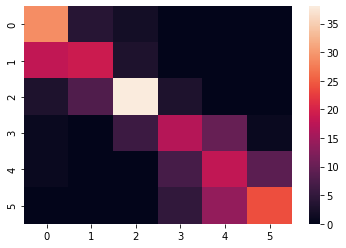

In [ ]:
# Evaluation with the confusion matrix
import seaborn
confusion_matrix = evaluate(reviews, sentiments, 'matrix')
report = evaluate(reviews, sentiments, 'report')
print(report)
seaborn.heatmap(confusion_matrix)
# precision    recall  f1-score   support

#            0       0.96      0.96      0.96       482
#            1       0.98      0.99      0.99      1322

#     accuracy                           0.98      1804
#    macro avg       0.97      0.97      0.97      1804
# weighted avg       0.98      0.98      0.98      1804